In [1]:
from __future__ import print_function
# To run on gpu
import os    
os.environ['THEANO_FLAGS'] = "device=gpu0"
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import *
from keras import callbacks
from keras.regularizers import l2, activity_l2
import keras
from pprint import *
%matplotlib inline
import matplotlib.pyplot as plt

Using Theano backend.
Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [2]:
opt = {
    'batch_size': 256,
    'nb_classes': 10,
    'nb_epoch':5,
    'data_augmentation': False,
    'lr':0.01,
    'momentum':0.9,
    'decay':1e-6,
    'nesterov':True,
    'init':'uniform',
    'optimizer':'sgd',
    'loss':'categorical_crossentropy',
    'img_rows':28,
    'img_cols':28
}

pprint(opt)

{'batch_size': 256,
 'data_augmentation': False,
 'decay': 1e-06,
 'img_cols': 28,
 'img_rows': 28,
 'init': 'uniform',
 'loss': 'categorical_crossentropy',
 'lr': 0.01,
 'momentum': 0.9,
 'nb_classes': 10,
 'nb_epoch': 5,
 'nesterov': True,
 'optimizer': 'sgd'}


In [3]:
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 1, opt['img_rows'], opt['img_cols'])
X_test = X_test.reshape(X_test.shape[0], 1, opt['img_rows'], opt['img_cols'])
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, opt['nb_classes'])
Y_test = np_utils.to_categorical(y_test, opt['nb_classes'])


X_train shape: (60000, 1, 28, 28)
60000 train samples
10000 test samples


In [4]:
def plotLogs(stats,name):
    epochs=list(range(1,opt['nb_epoch']+1))
    train_acc= stats['acc']
    train_loss= stats['loss']
    test_acc= stats['val_acc']
    test_loss= stats['val_loss']

    acc_plot = plt.plot()
    plt.plot(epochs, train_acc,'b-',label='Training Accuracy')
    plt.plot(epochs, test_acc, 'r-',label='Testing Accuracy')
    plt.title('Progression of Accuracy for '+name)
    plt.xlabel('No. of Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.show()

    loss_plot = plt.plot()
    plt.plot(epochs, train_loss,'b-',label='Training Loss') 
    plt.plot(epochs, test_loss, 'r-',label='Testing Loss')
    plt.title('Progression of Loss for '+name)
    plt.xlabel('No. of Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.show()

In [5]:
def reset_model(init_type,opt):
    model = Sequential()

    model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(1, opt['img_rows'], opt['img_cols']), init= init_type ))
    model.add(Activation('relu'))
    model.add(Convolution2D(32, 3, 3, init=  init_type))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Convolution2D(64, 3, 3, border_mode='same',init= init_type))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, 3, 3, init=init_type))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512,init=init_type))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(opt['nb_classes'], init=init_type))
    model.add(Activation('softmax'))
    
    optim = SGD(momentum=opt['momentum'])

    return optim,model

In [6]:
def reset_regularized_model(init_type,opt):
    model = Sequential()

    model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(1, opt['img_rows'], opt['img_cols']), init= init_type ,W_regularizer=l2(0.01)))
    model.add(Activation('relu'))
    model.add(Convolution2D(32, 3, 3, init=  init_type,W_regularizer=l2(0.01)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Convolution2D(64, 3, 3, border_mode='same',init= init_type,W_regularizer=l2(0.01)))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, 3, 3, init=init_type,W_regularizer=l2(0.01)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512,init=init_type,W_regularizer=l2(0.01)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(opt['nb_classes'], init=init_type,W_regularizer=l2(0.01)))
    model.add(Activation('softmax'))
    
    optim = SGD(momentum=opt['momentum'])

    return optim,model

In [7]:
init_type=opt['init']
#optim,model = reset_model(init_type,opt)
optim,model = reset_regularized_model(init_type,opt)

In [8]:
model.compile(loss=opt['loss'],
                  optimizer=optim,
                  metrics=['accuracy'])

stats= model.fit(X_train, Y_train,
              batch_size=opt['batch_size'],
              nb_epoch=opt['nb_epoch'],
              validation_data=(X_test, Y_test),
              shuffle=True)

stats= stats.history

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 7s - loss: 7.2594 - acc: 0.1124 - val_loss: 2.2871 - val_acc: 0.1236
Epoch 2/5
60000/60000 [==============================] - 7s - loss: 3.0322 - acc: 0.6656 - val_loss: 0.1727 - val_acc: 0.9492
Epoch 3/5
60000/60000 [==============================] - 7s - loss: 1.1580 - acc: 0.9321 - val_loss: 0.1210 - val_acc: 0.9637
Epoch 4/5
60000/60000 [==============================] - 7s - loss: 0.6683 - acc: 0.9480 - val_loss: 0.0980 - val_acc: 0.9670
Epoch 5/5
60000/60000 [==============================] - 7s - loss: 0.4794 - acc: 0.9544 - val_loss: 0.0904 - val_acc: 0.9717


In [13]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 1s     
Test score: 0.0904421995839
Test accuracy: 0.9717


In [14]:
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 32, 28, 28)    320         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 32, 28, 28)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 26, 26)    9248        activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 32, 26, 26)    0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [11]:
def weightdistribution(weights):
    maxim= np.amax(weights)
    minim= np.amin(weights)
    step= (maxim-minim)/255
    freq= np.zeros(256)
    #print(type(freq))
    m = weights.shape[0]
    for i in range(0,m):
        e= weights[i]
        k=0
        while (e >= minim + k*step):
            k+=1
        if ((k == 1) or ((minim + k*step - e) <= (e - minim + (k-1)*step))):
            freq[k-1]+= 1
        else:
            freq[k-2]+= 1
                
    #np.savetxt('/users/soham.saha/compression/clusters_x.txt',(np.linspace(minim,maxim,256)))
    #np.savetxt('/users/soham.saha/compression/freq_y.txt',freq)
    #print(len(np.linspace(minim,maxim,256)))
    return ((np.linspace(minim,maxim,256)),(freq))

(32, 1, 3, 3)


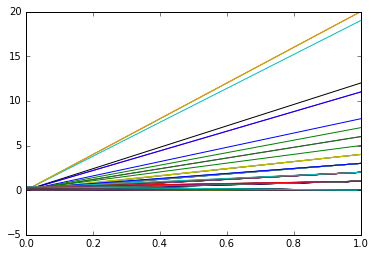

In [12]:
mnist_weights = model.get_weights()
weight = mnist_weights[0]

print(weight.shape)
plt.plot(weightdistribution(weight.flatten()))
plt.show()